In [1]:
from tinylang.language import PCFG
from tinylang.train import train, init_model
from transformers import GPT2Config, GPT2LMHeadModel
import torch

from sklearn.decomposition import PCA
import pandas as pd
import plotnine as p9
from sklearn.feature_selection import r_regression

device = "cpu"

/Users/aryamanarora/Documents/Code/tinylang/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
pcfg = PCFG(num_terminals=20, num_nonterminals=10, max_rhs_len=10, max_rules_per_nt=5, max_depth=10, head_position="left", mask_nonquery=False)
# pcfg = PCFG(num_terminals=20, num_nonterminals=10, max_rhs_len=4, max_rules_per_nt=3, max_depth=5, head_position="left")

In [5]:
model_dict = {}
loss_dict = {}

# defaults
n_layer = 2
n_embd = 64
n_head = 2
n_inner = 4

for n_layer in range(0, 2):
# for n_embd in [16, 32, 64, 128]:   
# for n_head in [1, 2, 4, 8]:
# for n_inner in [0.5, 1, 2, 4]:
    config = GPT2Config(
        vocab_size=pcfg.vocab_size,
        n_positions=1024,
        n_embd=n_embd,
        n_layer=n_layer,
        n_head=n_head,
        n_inner=int(n_inner * n_embd),
        activation_function="gelu_new",
        resid_pdrop=0.0,
        embd_pdrop=0.0,
        attn_pdrop=0.0,
        layer_norm_epsilon=1e-5,
        initializer_range=0.02,
        summary_type="cls_index",
    )
    model = GPT2LMHeadModel(config).to(device)
    losses = train(model, pcfg, num_steps=10000)
    model.eval()
    loss_dict[n_layer] = losses
    model_dict[n_layer] = model


Parameters: 0.067264M


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:  27%|██▋       | 2687/10000 [00:18<00:51, 142.44it/s, eval_loss=2.51, eval_prob=0.118, eval_prob_CHILD=0.277, eval_prob_PARENT=0.0443, eval_prob_SIBLING=0.0525, loss=2.42] 


KeyboardInterrupt: 

In [8]:
combined_cols = []
for d in loss_dict:
    for i in range(len(loss_dict[d]["train_loss"])):
        add = {metric: loss_dict[d][metric][i] for metric in loss_dict[d]}
        add["index"] = i
        add["d"] = d
        combined_cols.append(add)
df = pd.DataFrame(combined_cols)
df = df.melt(id_vars=["index", "d"])
df

,index,d,variable,value
0,0,0,train_loss,3.210051
1,1,0,train_loss,3.172631
2,2,0,train_loss,3.127628
3,3,0,train_loss,3.187535
4,4,0,train_loss,3.169662
...,...,...,...,...
179995,9995,2,eval_prob_CHILD,0.687677
179996,9996,2,eval_prob_CHILD,0.688400
179997,9997,2,eval_prob_CHILD,0.688775
179998,9998,2,eval_prob_CHILD,0.689177


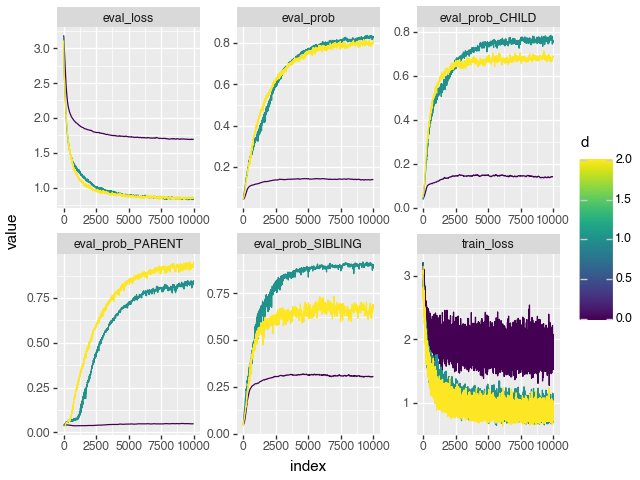

In [9]:
%config InlineBackend.figure_format = 'png'
plot = (
    p9.ggplot(df, p9.aes(x="index", y="value", color="d", group="d")) +
    p9.geom_line() +
    p9.facet_wrap("variable", scales="free")
    # p9.scale_x_log10()
)
plot.show()